<a href="https://colab.research.google.com/github/chris051091/Seminario-3/blob/master/preprocess/src/Testeo_Vapor_de_Agua.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Limpieza datos de Vapor de Agua

In [1]:
import pandas as pd
import numpy as np
import os
import re
from functools import reduce
import matplotlib.pyplot as plt

from google.colab import drive
drive.mount('/content/drive')

%matplotlib inline

Mounted at /content/drive


In [2]:
PATH_DRIVE = 'drive/MyDrive/Seminario-3-master'
PATH_DADOS = '/dados/'

NOMBRE_ESTACION = 'palanquero'

PATH_FINAL_DATOS = PATH_DRIVE + PATH_DADOS + '/'
PATH_FINAL_DATOS_TRATADOS = PATH_DRIVE + '/preprocess' + PATH_DADOS + NOMBRE_ESTACION + '/tratados/'

FILE_DATOS_ENTRADA = 'BAPA_IdeamMetData_23035030_data.txt'
FILE_DATOS_TRATADOS = NOMBRE_ESTACION.lower() + '_tratados_pwv.csv'


In [3]:
with open(f'{PATH_FINAL_DATOS}{FILE_DATOS_ENTRADA}') as f:
  columns = f.readline().split()
  columns.remove('sfcPint')
  columns.remove('sfcTint')
  list_data = []
  i = 0
  for line in f:
    dict_data = {}
    line_split = line.strip().split(' ')
    for col, value in zip(columns, line_split):
       dict_data[col] = value
    list_data.append(dict_data)
df = pd.DataFrame(list_data)
df

,YYYY,MM,DD,hh,mm,ss,TROWET,TROTOT,STDEV,sfcP,sfcT,sfcRH,sfcWS,sfcWD,ZWD,PWV,sfcPclim,sfcTclim,ZWDfromclim,PWVfromclim
0,2010,10,01,07,30,00,319.1,2606.0,3.0,992.0,28.4,-99.9,-99.9,-99.9,341.2,55.87,992.3,26.5,340.6,55.50
1,2010,10,01,07,35,00,318.9,2605.8,3.0,992.1,28.5,-99.9,-99.9,-99.9,340.9,55.83,992.4,26.6,340.3,55.47
2,2010,10,01,07,40,00,318.8,2605.7,2.9,992.1,28.5,-99.9,-99.9,-99.9,340.7,55.80,992.4,26.7,340.1,55.45
3,2010,10,01,07,45,00,318.7,2605.4,2.8,992.2,28.5,-99.9,-99.9,-99.9,340.4,55.74,992.4,26.9,339.7,55.41
4,2010,10,01,07,50,00,318.7,2605.4,2.7,992.2,28.6,-99.9,-99.9,-99.9,340.3,55.73,992.5,27.0,339.6,55.41
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
835150,2019,12,31,18,35,00,343.3,2626.6,1.7,-99.9,-99.9,-99.9,-99.9,-99.9,-99.9,-99.90,987.0,26.3,373.4,60.83
835151,2019,12,31,18,40,00,343.4,2626.7,1.7,-99.9,-99.9,-99.9,-99.9,-99.9,-99.9,-99.90,987.0,26.3,373.3,60.80
835152,2019,12,31,18,45,00,343.2,2626.6,1.8,-99.9,-99.9,-99.9,-99.9,-99.9,-99.9,-99.90,987.1,26.2,373.0,60.74
835153,2019,12,31,18,50,00,343.3,2626.7,2.0,-99.9,-99.9,-99.9,-99.9,-99.9,-99.9,-99.90,987.2,26.1,372.9,60.72


In [4]:
df['FECHA'] = df['YYYY'] + '-' + df['MM'] + '-' + df['DD'] + ' ' + df['hh'] + ':' + df['mm'] + ':' + df['ss']
df['FECHA'] = pd.to_datetime(df['FECHA'], format='%Y-%m-%d %H:%M:%S').dt.tz_localize('America/Bogota')

In [5]:
dfVar = df[['FECHA', 'PWV']].copy()
dfVar = dfVar.sort_values(by=['FECHA']).reset_index(drop = True)
dfVar['PWV'] = pd.to_numeric(dfVar['PWV'], errors='coerce')
# dfVar.min()

## Test de rango fijo

In [6]:
pwv_max = 80.
pwv_min = 30.
lamb_func = lambda r: np.nan if ((r > pwv_max) | (r < pwv_min)) else r

dfVar['PWV_RANGO_FIJO'] = dfVar['PWV'].apply(lamb_func)
dfVar

,FECHA,PWV,PWV_RANGO_FIJO
0,2010-10-01 07:30:00-05:00,55.87,55.87
1,2010-10-01 07:35:00-05:00,55.83,55.83
2,2010-10-01 07:40:00-05:00,55.80,55.80
3,2010-10-01 07:45:00-05:00,55.74,55.74
4,2010-10-01 07:50:00-05:00,55.73,55.73
...,...,...,...
835150,2019-12-31 18:35:00-05:00,-99.90,NaN
835151,2019-12-31 18:40:00-05:00,-99.90,NaN
835152,2019-12-31 18:45:00-05:00,-99.90,NaN
835153,2019-12-31 18:50:00-05:00,-99.90,NaN


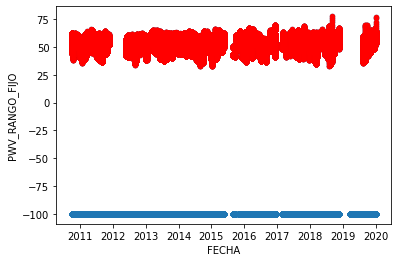

In [7]:
ax = dfVar.plot(kind = 'scatter', x='FECHA', y='PWV')
dfVar.plot(kind = 'scatter', x='FECHA', y='PWV_RANGO_FIJO', ax=ax, color='red')
# plt.savefig()

In [8]:
## Para filtrar los valores finales
dfFinal = dfVar[~dfVar['PWV_RANGO_FIJO'].isnull()]
dfFinal 

,FECHA,PWV,PWV_RANGO_FIJO
0,2010-10-01 07:30:00-05:00,55.87,55.87
1,2010-10-01 07:35:00-05:00,55.83,55.83
2,2010-10-01 07:40:00-05:00,55.80,55.80
3,2010-10-01 07:45:00-05:00,55.74,55.74
4,2010-10-01 07:50:00-05:00,55.73,55.73
...,...,...,...
835138,2019-12-31 17:35:00-05:00,60.37,60.37
835139,2019-12-31 17:40:00-05:00,60.32,60.32
835140,2019-12-31 17:45:00-05:00,60.31,60.31
835141,2019-12-31 17:50:00-05:00,60.27,60.27


In [9]:
print(f'Datos iniciales : {dfVar.shape[0]}')
print(f'Datos finales después de testes : {dfFinal.shape[0]}')
print(f'Datos no nulos que fueron eliminados en los testes : {dfVar.shape[0] - dfFinal.shape[0] - dfVar[dfVar["PWV"].isnull()].shape[0]}')

Datos iniciales : 835155
Datos finales después de testes : 574029
Datos no nulos que fueron eliminados en los testes : 261126


# Datos Finales a salvar

In [10]:
dfSave = dfFinal[(dfFinal['FECHA'] > '2010-12-31 23:59:59') & 
                 (dfFinal['FECHA'] < '2018-01-01 00:00:00')]

dfSave

,FECHA,PWV,PWV_RANGO_FIJO
15182,2011-01-01 00:05:00-05:00,48.16,48.16
15183,2011-01-01 00:10:00-05:00,48.19,48.19
15184,2011-01-01 00:15:00-05:00,48.20,48.20
15185,2011-01-01 00:20:00-05:00,48.24,48.24
15186,2011-01-01 00:25:00-05:00,48.31,48.31
...,...,...,...
661319,2017-12-31 23:35:00-05:00,57.51,57.51
661320,2017-12-31 23:40:00-05:00,57.53,57.53
661321,2017-12-31 23:45:00-05:00,57.55,57.55
661322,2017-12-31 23:50:00-05:00,57.57,57.57


# Datos nulos

In [11]:
dfNull = dfVar[dfVar['PWV_RANGO_FIJO'].isnull()]
dfNull = dfNull[(dfNull['FECHA'] > '2010-12-31 23:59:59') & 
                (dfNull['FECHA'] < '2018-01-01 00:00:00')]
dfNull

,FECHA,PWV,PWV_RANGO_FIJO
15181,2011-01-01 00:00:00-05:00,-99.9,NaN
15193,2011-01-01 01:00:00-05:00,-99.9,NaN
15205,2011-01-01 02:00:00-05:00,-99.9,NaN
15217,2011-01-01 03:00:00-05:00,-99.9,NaN
15227,2011-01-01 09:30:00-05:00,-99.9,NaN
...,...,...,...
661264,2017-12-31 19:00:00-05:00,-99.9,NaN
661276,2017-12-31 20:00:00-05:00,-99.9,NaN
661288,2017-12-31 21:00:00-05:00,-99.9,NaN
661300,2017-12-31 22:00:00-05:00,-99.9,NaN


In [12]:
438752 + 207391

646143

In [13]:
12 * 24 * 365 * 7

735840

In [14]:
dfSave[['FECHA', 'PWV_RANGO_FIJO']].rename(columns = {'PWV_RANGO_FIJO': 'PWV'}).to_csv(PATH_FINAL_DATOS_TRATADOS + FILE_DATOS_TRATADOS, header=True, index=False, sep = ';')